# Home Credit Analysis

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from imblearn import under_sampling
from collections import defaultdict

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from xgboost import XGBClassifier 

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [68]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load Data

In [69]:
df = pd.read_csv("application_train.csv")
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Data Preprocessing

Pada data preprocessing kita membutuhkan data yang bersih sehingga mampu diterapkan pada beberapa model machine learning.

Tahapan-tahapan yang perlu dilakukan adalah:
1. Mengubah value pada kolom contains = days menjadi nilai mutlak
2. Handle Missing Value
3. Feature Extraction
- kolom NAME_INCOME_TYPE -> Unemployed, Student, Businessman, dan Maternity leave diubah menjadi Others
- kolom NAME_EDUCATION_TYPE -> 
    - Lower secondary diubah menjadi Secondary / secondary special
    - Incomplete higher menjadi Higher education
- kolom NAME_FAMILY_STATUS -> 
    - Civil marriage menjadi Married
    - Separated, dan Widow diubah menjadi Others
4. Melakukan feature selection
5. Handle outliers with Yeo-Johnson transformation
6. Split data 
7. Feature Encoding dengan One Hot Encoding (OHE)
8. Split Data Train and Test
9. Handle Class Imbalance with Undersampling

### Change days to absolute no.

In [70]:
data_abs = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']

for col in data_abs:
  df[col] = df[col].abs()

## Handling Missing Value

In [71]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [72]:
cek_null = missing_data(df)
cek_null[cek_null['Total'] > 0]

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


### Handle missing value <= 20%

In [73]:
# Hapus rows dari kolom yang persentase nullnya < 20
drop_null = cek_null[(cek_null['Percent'] <= 20) & (cek_null['Percent'] > 0)]
drop_rows_null = drop_null.T.columns.values
drop_rows_null

array(['EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_TYPE_SUITE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY',
       'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'], dtype=object)

In [74]:
df.dropna(inplace=True, subset = drop_rows_null)

### Handle missing value > 60%

In [75]:
#Hapus kolom yang persentase nullnya >60
drop = cek_null[cek_null['Percent'] > 60]
drop_cols_null = drop.T.columns.values
drop_cols_null

array(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE',
       'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE'], dtype=object)

In [76]:
df = df.drop(columns = drop_cols_null)

### Handle missing value < 60%

- Handle missing value untuk kolom dengan tipe data number dengan mean dan median
- Handle missing value untuk kolom dengan tipe data string dengan mode

In [77]:
cek_null = missing_data(df)
data = cek_null[cek_null['Total'] > 0]
rep_mis_value = data.T.columns.values
rep_mis_value

array(['LANDAREA_MODE', 'LANDAREA_AVG', 'LANDAREA_MEDI',
       'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG',
       'EXT_SOURCE_1', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG',
       'NONLIVINGAREA_MEDI', 'ELEVATORS_MODE', 'ELEVATORS_MEDI',
       'ELEVATORS_AVG', 'WALLSMATERIAL_MODE', 'APARTMENTS_MEDI',
       'APARTMENTS_AVG', 'APARTMENTS_MODE', 'ENTRANCES_AVG',
       'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'LIVINGAREA_MEDI',
       'LIVINGAREA_MODE', 'LIVINGAREA_AVG', 'HOUSETYPE_MODE',
       'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'TOTALAREA_MODE',
       'EMERGENCYSTATE_MODE', 'OCCUPATION_TYPE'], dtype=object)

In [78]:
df_miss = pd.DataFrame(df, columns = rep_mis_value )
df_miss.head()

,LANDAREA_MODE,LANDAREA_AVG,LANDAREA_MEDI,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,BASEMENTAREA_AVG,EXT_SOURCE_1,NONLIVINGAREA_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,ELEVATORS_MODE,ELEVATORS_MEDI,ELEVATORS_AVG,WALLSMATERIAL_MODE,APARTMENTS_MEDI,APARTMENTS_AVG,APARTMENTS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,LIVINGAREA_MEDI,LIVINGAREA_MODE,LIVINGAREA_AVG,HOUSETYPE_MODE,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MODE,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OCCUPATION_TYPE
0,0.0377,0.0369,0.0375,0.0369,0.0383,0.0369,0.083037,0.0,0.0,0.0,0.0,0.0,0.0,"Stone, brick",0.025,0.0247,0.0252,0.069,0.069,0.069,0.0193,0.0198,0.019,block of flats,0.0833,0.0833,0.0833,0.9722,0.9722,0.9722,0.0149,No,Laborers
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Laborers
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Laborers
6,NaN,NaN,NaN,NaN,NaN,NaN,0.774761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accountants
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Managers


In [79]:
df_miss.select_dtypes('number').columns

Index(['LANDAREA_MODE', 'LANDAREA_AVG', 'LANDAREA_MEDI', 'BASEMENTAREA_MEDI',
       'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG', 'EXT_SOURCE_1',
       'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI',
       'ELEVATORS_MODE', 'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'APARTMENTS_MEDI',
       'APARTMENTS_AVG', 'APARTMENTS_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI',
       'ENTRANCES_MODE', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE',
       'LIVINGAREA_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMAX_AVG',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BEGINEXPLUATATION_MODE', 'TOTALAREA_MODE'],
      dtype='object')

In [80]:
df_miss.select_dtypes('number').skew().abs()<1

LANDAREA_MODE                   False
LANDAREA_AVG                    False
LANDAREA_MEDI                   False
BASEMENTAREA_MEDI               False
BASEMENTAREA_MODE               False
BASEMENTAREA_AVG                False
EXT_SOURCE_1                     True
NONLIVINGAREA_MODE              False
NONLIVINGAREA_AVG               False
NONLIVINGAREA_MEDI              False
ELEVATORS_MODE                  False
ELEVATORS_MEDI                  False
ELEVATORS_AVG                   False
APARTMENTS_MEDI                 False
APARTMENTS_AVG                  False
APARTMENTS_MODE                 False
ENTRANCES_AVG                   False
ENTRANCES_MEDI                  False
ENTRANCES_MODE                  False
LIVINGAREA_MEDI                 False
LIVINGAREA_MODE                 False
LIVINGAREA_AVG                  False
FLOORSMAX_MEDI                  False
FLOORSMAX_MODE                  False
FLOORSMAX_AVG                   False
YEARS_BEGINEXPLUATATION_MEDI    False
YEARS_BEGINE

- Kolom EXT_SOURCE_1 memiliki distribusi normal, maka missing value akan diinput nilai mean. Sedangkan kolom lainnya akan diinput dengan nilai median

In [81]:
# handling missing values with mean
df['EXT_SOURCE_1'].fillna(df['EXT_SOURCE_1'].mean(), inplace=True)

In [82]:
# handling missing values with median
data_rep_med = ['LANDAREA_MODE', 'LANDAREA_AVG', 'LANDAREA_MEDI', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 
                'BASEMENTAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI',
                'ELEVATORS_MODE', 'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_AVG', 
                'APARTMENTS_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'LIVINGAREA_MEDI', 
                'LIVINGAREA_MODE', 'LIVINGAREA_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMAX_AVG',
                'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_AVG',
                'YEARS_BEGINEXPLUATATION_MODE', 'TOTALAREA_MODE']

for col in data_rep_med:
    df[col].fillna(df[col].median(), inplace=True)       

In [83]:
df_miss.select_dtypes('object').columns

Index(['WALLSMATERIAL_MODE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE',
       'OCCUPATION_TYPE'],
      dtype='object')

In [84]:
# handling missing values with mode
data_rep_mode = ['WALLSMATERIAL_MODE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'OCCUPATION_TYPE']

for col in data_rep_mode:
    df[col].fillna(df[col].mode()[0], inplace=True)

## Feature Extraction

In [85]:
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].replace(['Unemployed', 'Student', 'Businessman', 'Maternity leave'],'Others')
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].replace(['Civil marriage'],'Married')
df['NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].replace(['Separated', 'Widow'],'Others')
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].replace(['Lower secondary'],'Secondary / secondary special')
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].replace(['Incomplete higher'],'Higher education')

## Feature Selection

In [86]:
# membuang feature yang kurang relevan

drop_feature = ['SK_ID_CURR', 'ORGANIZATION_TYPE', 'FLAG_MOBIL', 'FLAG_DOCUMENT_2']
df = df.drop(columns = drop_feature)

Alasan drop feature:
- kolom SK_ID_CURR -> memiliki value unique
- kolom ORGANIZATION_TYPE, FLAG_MOBIL, FLAG_DOCUMENT_2 -> memiliki banyak value

## Handling Outliers

In [87]:
# Cek nilai skew pada setiap feature numerik
data = df.drop("TARGET", axis=1)
cek_skew = data.select_dtypes('number').columns

for col in range(0, len(cek_skew)):
  skew = df[cek_skew[col]].skew(axis = 0, skipna = True)
  print(f'{cek_skew[col]}: {skew}')

CNT_CHILDREN: 1.9246778630698829
AMT_INCOME_TOTAL: 383.1733417966111
AMT_CREDIT: 1.199462751270008
AMT_ANNUITY: 1.5186847928482707
AMT_GOODS_PRICE: 1.308811896441282
REGION_POPULATION_RELATIVE: 1.4877272899109353
DAYS_BIRTH: 0.11122776936059867
DAYS_EMPLOYED: 1.6671428805232118
DAYS_REGISTRATION: 0.5840971830973996
DAYS_ID_PUBLISH: -0.39018832579954754
FLAG_EMP_PHONE: -1.6677564237469646
FLAG_WORK_PHONE: 1.5038844278608159
FLAG_CONT_MOBILE: -22.445782312383987
FLAG_PHONE: 0.9365938128921746
FLAG_EMAIL: 3.760175888842152
CNT_FAM_MEMBERS: 0.9735664470967024
REGION_RATING_CLIENT: 0.10378893711144932
REGION_RATING_CLIENT_W_CITY: 0.07348859273115517
HOUR_APPR_PROCESS_START: -0.01814853566572272
REG_REGION_NOT_LIVE_REGION: 8.217958645845247
REG_REGION_NOT_WORK_REGION: 4.1904949646303145
LIVE_REGION_NOT_WORK_REGION: 4.73619757505121
REG_CITY_NOT_LIVE_CITY: 3.235694644174668
REG_CITY_NOT_WORK_CITY: 1.3150069270705707
LIVE_CITY_NOT_WORK_CITY: 1.6914943751793075
EXT_SOURCE_1: -0.1453995517879967

In [88]:
# Me-list feature yang skew
data_skew = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
             'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
             'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
             'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
             'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
             'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
             'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
             'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
             'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1',
             'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
             'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
             'FLOORSMAX_AVG', 'LANDAREA_AVG', 'LIVINGAREA_AVG',
             'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
             'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
             'FLOORSMAX_MODE', 'LANDAREA_MODE', 'LIVINGAREA_MODE',
             'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
             'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
             'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI',
             'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
             'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
             'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
              'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
             'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
             'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
             'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
             'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
             'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
             'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
             'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
             'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
             'AMT_REQ_CREDIT_BUREAU_YEAR']

In [89]:
# Yeo-Johnson Transformation
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'yeo-johnson')

for col in range(0, len(data_skew)):
  df[data_skew[col]] = pt.fit_transform(df[[data_skew[col]]])
     

In [90]:
# Cek nilai skew setelah dilakukan Yeo-Johnson Transformation
for col in range(0, len(data_skew)):
  skew = df[data_skew[col]].skew(axis = 0, skipna = True)
  print(f'{data_skew[col]}: {skew}')

CNT_CHILDREN: 0.8614844071616897
AMT_INCOME_TOTAL: -0.007473069246665073
AMT_CREDIT: -0.025873338713984468
AMT_ANNUITY: -0.00425891948573985
AMT_GOODS_PRICE: -0.019621510574269946
REGION_POPULATION_RELATIVE: 0.09430740822698384
DAYS_EMPLOYED: 0.07748225450929705
DAYS_REGISTRATION: -0.18467412397899233
DAYS_ID_PUBLISH: -0.40970888745906087
FLAG_EMP_PHONE: -1.6677564237469653
FLAG_WORK_PHONE: 1.5038844278608157
FLAG_CONT_MOBILE: -22.445782312383958
FLAG_PHONE: 0.9365938128921739
FLAG_EMAIL: 3.760175888842154
CNT_FAM_MEMBERS: 0.005786218686457938
HOUR_APPR_PROCESS_START: -0.011779306272098422
REG_REGION_NOT_LIVE_REGION: 8.217958645845245
REG_REGION_NOT_WORK_REGION: 4.190494964630316
LIVE_REGION_NOT_WORK_REGION: 4.736197575051212
REG_CITY_NOT_LIVE_CITY: 3.2356946441746657
REG_CITY_NOT_WORK_CITY: 1.3150069270705702
LIVE_CITY_NOT_WORK_CITY: 1.6914943751793083
EXT_SOURCE_1: 0.06825566572272533
EXT_SOURCE_3: -0.10111433030707352
APARTMENTS_AVG: -0.15167188717118193
BASEMENTAREA_AVG: -0.3163238

In [91]:
df.TARGET.value_counts()

0    225248
1     19032
Name: TARGET, dtype: int64

## Split Data

In [92]:
X = df.drop(labels=['TARGET'], axis=1)
y = df[['TARGET']]

## Feature Encoding

In [93]:
# membuat One Hot Encoding (OHE) untuk feature kategorik
X_dummy = pd.get_dummies(X)

## Split Data Test dan Train

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size = 0.3, stratify=y, random_state = 42)

print('Dimensi Train:', X_train.shape)
print('Dimensi Test:', X_test.shape)

Dimensi Train: (170996, 156)
Dimensi Test: (73284, 156)


## Handling Class Imbalance

In [95]:
y_train['TARGET'].value_counts()

0    157674
1     13322
Name: TARGET, dtype: int64

In [96]:
(13322/len(y_train))*100

7.790825516386349

### Undersampling

In [97]:
from imblearn import under_sampling
X_under, y_under = under_sampling.RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)

In [98]:
y_under['TARGET'].value_counts()

0    13322
1    13322
Name: TARGET, dtype: int64

# Modelling

## Experiment 1

In [99]:
## UDF for experimenting several classification models
def experiment(X_train,X_test,y_train,y_test):
    """
    This function want to do an experiment for several models.
    We just need data input

    Parameter
    ---------
    X_train = training data contains several features
    X_test = testing data contains several features
    y_train = train target
    y_test = test target
    """
    result = defaultdict(list)
    
    #knn = KNeighborsClassifier()
    logreg = LogisticRegression()
    dtc = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    #grad = GradientBoostingClassifier()
    xgb = XGBClassifier()
    ab = AdaBoostClassifier()

    list_model = [#('K-Nearest Neighbor',knn),
                  ('Logistic Regression',logreg),
                  ('Decision Tree',dtc),
                  ('Random Forest',rf),
                  ('XGB Classifier', xgb), 
                  ('AdaBoost Classifier', ab)
                  #('Gradient Boosting',grad)
                 ]

    for model_name,model in list_model:
        #start = dt.now()
        model.fit(X_train,y_train)
        #duration = (dt.now()-start).total_seconds()
        
        y_pred = model.predict(X_test)
        #y_pred_train = model.predict(X_train)
        y_pred_proba = model.predict_proba(X_test)
        y_pred_proba_train = model.predict_proba(X_train)
        
        accuracy = accuracy_score(y_test,y_pred)
        recall = recall_score(y_test,y_pred)
        precision = precision_score(y_test,y_pred)
        f1_test = f1_score(y_test, y_pred)
        roc_auc_train = roc_auc_score(y_train, y_pred_proba_train[:, 1])
        roc_auc_test = roc_auc_score(y_test, y_pred_proba[:, 1])
        
        result['model_name'].append(model_name)
        result['model'].append(model)
        result['accuracy'].append(accuracy)
        result['recall'].append(recall)
        result['precision'].append(precision)
        #result['duration'].append(duration)
        result['f1_test'].append(f1_test)
        result['roc_auc_train'].append(roc_auc_train)
        result['roc_auc_test'].append(roc_auc_test)
        
    return result

In [100]:
# Experiment 1 with data default
result = experiment(X_train, X_test, y_train, y_test)
result = pd.DataFrame(result)
result

,model_name,model,accuracy,recall,precision,f1_test,roc_auc_train,roc_auc_test
0,Logistic Regression,LogisticRegression(),0.922043,0.000000,0.000000,0.000000,0.632590,0.635206
1,Decision Tree,DecisionTreeClassifier(),0.854634,0.162872,0.136704,0.148645,1.000000,0.537980
2,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.922098,0.001051,0.545455,0.002098,1.000000,0.723569
3,XGB Classifier,"XGBClassifier(base_score=None, booster=None, c...",0.921920,0.032224,0.484211,0.060427,0.871182,0.753884
4,AdaBoost Classifier,"(DecisionTreeClassifier(max_depth=1, random_st...",0.922466,0.023818,0.557377,0.045684,0.753658,0.751088


In [101]:
# Experiment 2 with data oversampling
result2 = experiment(X_under, X_test, y_under, y_test)
result2 = pd.DataFrame(result2)
result2

,model_name,model,accuracy,recall,precision,f1_test,roc_auc_train,roc_auc_test
0,Logistic Regression,LogisticRegression(),0.663978,0.680385,0.145587,0.239852,0.729679,0.731278
1,Decision Tree,DecisionTreeClassifier(),0.583634,0.593345,0.107286,0.181716,1.000000,0.588079
2,Random Forest,"(DecisionTreeClassifier(max_features='sqrt', r...",0.698570,0.662347,0.157952,0.255075,1.000000,0.744766
3,XGB Classifier,"XGBClassifier(base_score=None, booster=None, c...",0.681186,0.678984,0.152590,0.249181,0.926831,0.743197
4,AdaBoost Classifier,"(DecisionTreeClassifier(max_depth=1, random_st...",0.690656,0.681611,0.157291,0.255599,0.754307,0.750387


In [102]:
final_model = result2['model'][4]
y_pred = final_model.predict(X_test)

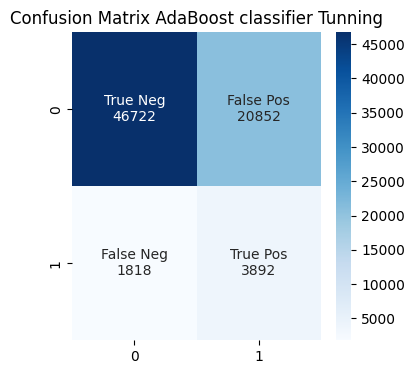

In [103]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix AdaBoost classifier Tunning')
# plt.savefig('Confusion Matrix random forest classifier.png')
plt.show()
          

- True Negative: ketika perusahaan mengira customer akan gagal bayar.
- False Negative: ketika perusahaan mengira customer akan gagal bayar padahal kenyataannya customer akan membayarnya.
- True Positive: ketika perusahaan mengira customer akan membayar.
- False Positive: ketika perusahaan mengira customer akan membayar padahal kenyataannya customer akan gagal bayar.

## Feature Importances

In [104]:
feature_imp = {}

feature_imp['columns'] = X_under.columns
feature_imp['feature_imp'] = result2['model'][4].feature_importances_

In [105]:
df_feature_imp = pd.DataFrame(feature_imp)
df_feature_imp = df_feature_imp.sort_values(['feature_imp'], ascending=False).head(20)

<Axes: xlabel='feature_imp', ylabel='columns'>

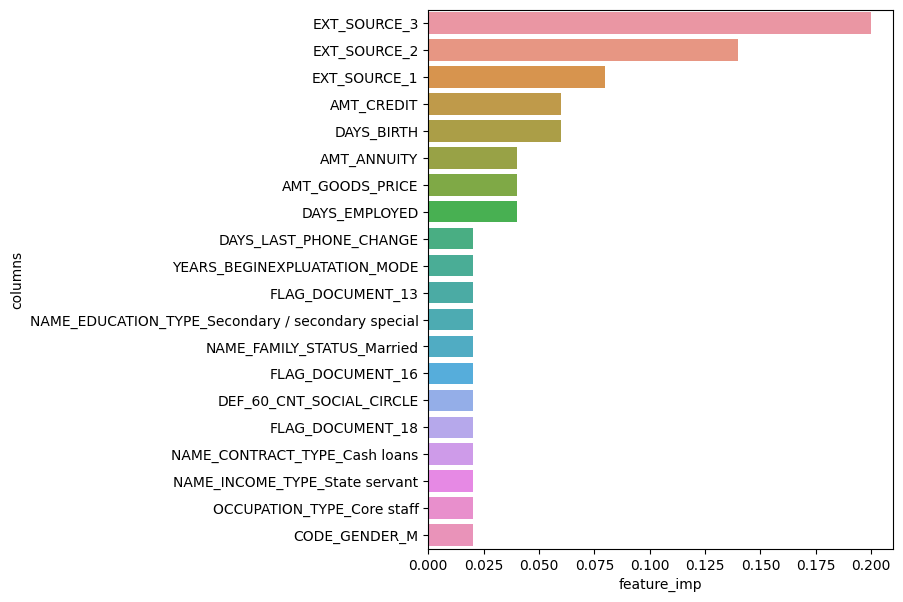

In [106]:
plt.figure(figsize=(6,7))
sns.barplot(x=df_feature_imp['feature_imp'], y=df_feature_imp['columns'])

# Business Recommendation

Berdasarkan EDA dan feature importance, dapat disimpulkan bahwa:
1. Semakin sedikit jumlah kredit yang dimiliki customer, maka semakin banyak customer yang dapat membayar.
2. Customer yang dapat bayar berada pada kisaran umur 30-40 tahun

Recommendation:
1. Kita bisa memberi credit kepada custumer yang berusia antara 30-40 tahun
2. Membatasi jumlah kredit yang bisa didapat oleh customer